# АБ тесты: введение в проблематику

АБ-тестирование - это подход, позволяющий проверять эффективность нововведений, и главным образом именно ради этого мы учили статистику. 

Задание, направленное на самостоятельный анализ набора данных и статистическую проверку результатов АБ-теста. 

# Кейс №1 - Приложение знакомств 

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

**Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.**

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

**Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.**

### Описание данных

- `user_id_1` – user id пользователя 1
- `user_id_2` – user id пользователя 2
- `group` – номер группы пользователя (0 - старый алгоритм, 1 - новый)
- `is_match` – случился ли "мэтч" (0 - нет, 1 - да)

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные и изучим их

2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположение, которое будем тестировать (есть ли значимые различия по проценту мэтчей между группами)
    - Построим график 
    
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
     
4. **Подводим итоги:**
    - Формулируем вывод и суммаризируем всё что было
    - Отвечаем на заданный вопрос: стоит ли включать новую систему поиска анкет на всех пользователей

## 1: загружаем
Еще раз список переменных:
- `user_id_1` – user id пользователя 1
- `user_id_2` – user id пользователя 2
- `group` – номер группы пользователя (0 - старый алгоритм, 1 - новый)
- `is_match` – случился ли "мэтч" (0 - нет, 1 - да)

In [2]:
# Выгружаем нужные библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2 
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

Читаем наш файл с логами и изучаем его

In [3]:
dating = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/dating_data.csv')

In [4]:
dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
dating.shape

(14514, 4)

In [6]:
dating.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [8]:
dating.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

Хорошие данные без пропусков

## 2: графики, гипотезы и тесты

**Наша метрика, которая отвечает за качество сервиса - это процент мэтчей среди всех пар. Необходимо статистически сравнить эту метрику в двух группах.**

In [12]:
# Количество пользователей в каждой группе
dating.group.value_counts()

1    9722
0    4792
Name: group, dtype: int64

In [13]:
#сколько юзеров в каждой группе
dating.groupby("group").user_id_1.nunique() 

group
0    501
1    499
Name: user_id_1, dtype: int64

In [14]:
dating.groupby("group").user_id_2.nunique()

group
0    501
1    499
Name: user_id_2, dtype: int64

Нет ли пересечения между группами пользователей? Для проверки этого нам пригодятся множества:

In [15]:
gr_01 = set(dating.query("group==0").user_id_1)
gr_11 = set(dating.query("group==1").user_id_1)

gr_01.intersection(gr_11)

set()

In [16]:
gr_02 = set(dating.query("group==0").user_id_2)
gr_12 = set(dating.query("group==1").user_id_2)

gr_02.intersection(gr_12)

set()

Пересечений нет

## Гипотеза 1: изменилось соотношение мэтчей и не-мэтчей

Посмотрим на кросстабуляцию:

In [17]:
pd.crosstab(dating.is_match, dating.group)

group,0,1
is_match,,
0,3858,5813
1,934,3909


**Наше предположение: процент мэтчей между группами значимо отличается**

Процентное соотношение мэтч/не мэтч (вне зависимости от группы):

In [18]:
dating.is_match.value_counts(normalize=True).mul(100)

0    66.632217
1    33.367783
Name: is_match, dtype: float64

Процентное соотношение мэтч/не мэтч (в зависимости от группы):

In [19]:
dating_group = dating.groupby('group').is_match.value_counts(normalize=True).mul(100).to_frame().rename(columns={'is_match' : 'percent'})
dating_group

percent
group is_match           
0     0         80.509182
      1         19.490818
1     0         59.792224
      1         40.207776

Видим, что по сравнению с 0 группой, в 1 группе мэтчей в 2 раза больше, что говорит о благоприятном действии нового алгоритма.

Посмотрим на полученные данные в виде графика:

Text(0.5, 1.0, 'Match density depending on group\n')

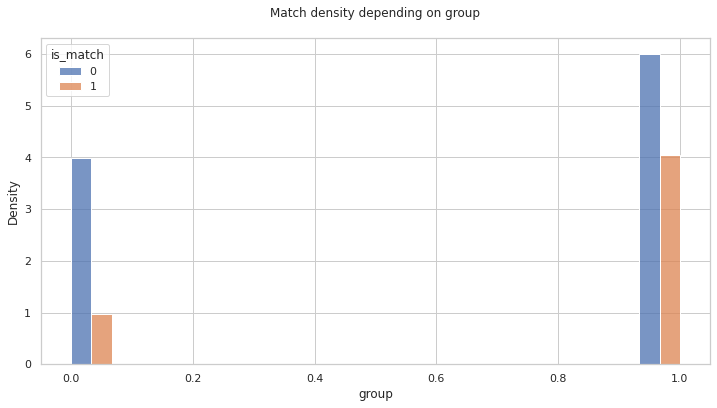

In [20]:
sns.histplot(data = dating, x = 'group', hue = 'is_match', stat = 'density', multiple = 'dodge')
plt.title('Match density depending on group\n')

**График наглядно демонстрирует сильное улучшение ситуации по мэтчам в тестовой группе**

Однако, делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [21]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(dating.is_match, dating.group))

In [22]:
stat, p

(618.6889141576197, 1.441829916366341e-136)

Через пингвин:

In [23]:
exp, obs, stats = pg.chi2_independence(data=dating, 
                                       x="group", 
                                       y="is_match") 
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


Интерпретируем результат:

In [24]:
# По статистике
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [26]:
# Либо по значению p-value
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Таким образом, гипотезу $H_0$ о том, что взаимосвязи между переменными нет, мы отклоняем.

**Можно сделать вывод, что процент мэтчей в контрольной и тестовой группе статистически значимо различаются, причем в тестовой группе он становится больше, т.е. новую систему поиска анкет стоит включать на всех пользователей.**

Есть вероятность, что другие факторы также сыграли роль для улучшение метрики, а не только новая система, но мы имеем только данные по мэтчам и можем судить только по ним. Но хотелось бы еще знать, что это за пользователи, как давно они пользуются приложением, есть ли среди них платные пользователи и т.д., для более полной картины.

**Ревью:**

Подготовка данных: 3/2

Очень хороший и обстоятельный предварительный анализ! Добавлю за него допбалл. Визуализация тоже ок.

Проверка гипотез: 2/4

Метрика вполне ок, метод её анализа тоже! Стоило ещё глянуть на количество активностей на пользователя в целом.

Дополнительные замечания (не влияют на оценку):

1. На самом деле тут подошёл бы и t-тест - так как среднее от 0 и 1 является пропорцией. Несмотря на то, что распределение выглядит совсем ненормальным, t-тест вполне мог бы тут быть даже чувствительнее хи-квадрата. В курсе об этом не рассказывалось, но факт интересный.

2. Ещё одна важная вещь - строго говоря, хи-квадрат подразумевает независимость отдельных наблюдений, а у нас в данных это не соблюдается (на одного и того же пользователя приходится несколько анкет). Здесь можно было бы прибегнуть к более продвинутым методам анализа, учитывающим такую структуру данных, но они, опять же, выходят далеко за пределы курса, а для наших целей и этого достаточно.

Рассуждения и выводы: 4/4

Всё хорошо!


Итого: 9/10

## *Гипотеза 2: изменилось число анкет на пользователя

In [27]:
prof_per_user = dating.groupby(["group", "user_id_1"], as_index=False).size()
prof_per_user

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


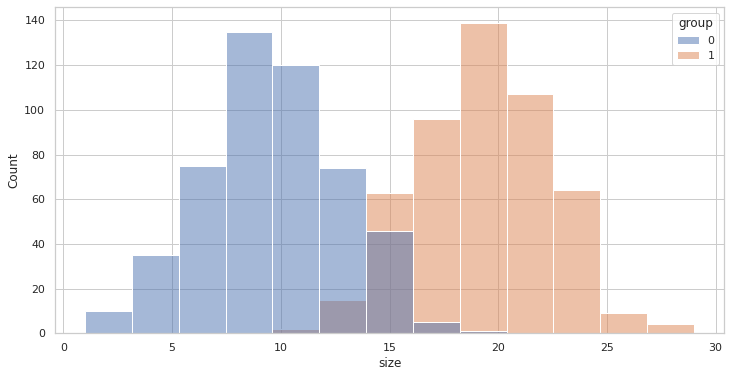

In [28]:
sns.histplot(data=prof_per_user, x="size", hue="group")

In [29]:
pg.ttest(x=prof_per_user.query("group==0")["size"], 
         y=prof_per_user.query("group==1")["size"]) #ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


In [30]:
pg.mwu(x=prof_per_user.query("group==0")["size"], 
       y=prof_per_user.query("group==1")["size"]) #Манн-Уитни - проверяет разницу стохастического доминирования

,U-val,alternative,p-val,RBC,CLES
MWU,3316.0,two-sided,6.905155e-157,0.973472,0.013264


## *Гипотеза 3: изменилось число мэтчей на пользователя

In [31]:
matches_per_user = dating.query("is_match==1").groupby(["group", "user_id_1"], as_index=False).size()
matches_per_user

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


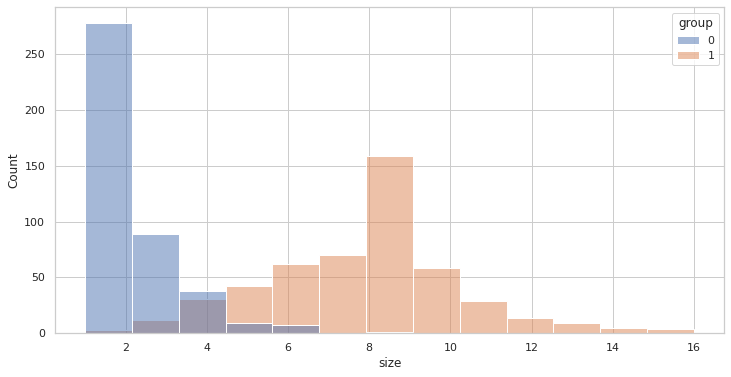

In [32]:
sns.histplot(data=matches_per_user, x="size", hue="group")

In [33]:
pg.ttest(x=matches_per_user.query("group==0")["size"], 
         y=matches_per_user.query("group==1")["size"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


In [34]:
pg.mwu(x=matches_per_user.query("group==0")["size"], 
       y=matches_per_user.query("group==1")["size"])

,U-val,alternative,p-val,RBC,CLES
MWU,3944.5,two-sided,1.570060e-141,0.962461,0.018769


## Дополнительный материал

Манн-Уитни может быть не самым оптимальным тестом - про это есть хороший [пост на Хабре от Avito](https://habr.com/ru/company/avito/blog/709596/). 

Для проверки гипотезы о различиях в распределениях есть более интересный метод - тест Колмогорова-Смирнова:

In [35]:
ss.ks_2samp(data1=matches_per_user.query("group==0")["size"], 
            data2=matches_per_user.query("group==1")["size"])

KstestResult(statistic=0.86734616189878, pvalue=3.775646878871376e-200)

Однако в посте не говорится про модифицированный вариант критерия Манна-Уитни, который проверяет стохастическое доминирование - так называемый тест Бруннера-Манцеля:

In [36]:
ss.brunnermunzel(x=matches_per_user.query("group==0")["size"], 
                 y=matches_per_user.query("group==1")["size"])

BrunnerMunzelResult(statistic=138.3937168748187, pvalue=0.0)

Наконец, мы можем обратиться к бутстрапу:

In [38]:
# ss.bootstrap([matches_per_user.query("group==0")["size"], 
#               matches_per_user.query("group==1")["size"]], 
#              statistic=lambda x, y: np.median(x) - np.median(y)) 
#BCa, медианы

In [39]:
# ss.bootstrap([matches_per_user.query("group==0")["size"], 
#               matches_per_user.query("group==1")["size"]], 
#              statistic=lambda x, y: np.mean(x) - np.mean(y)) #BCa, средние

In [40]:
pg.compute_bootci(matches_per_user.query("group==0")["size"], 
                  matches_per_user.query("group==1")["size"], 
                  func=lambda x, y: np.median(x) - np.median(y)) #cper, медианы

array([-6., -6.])

In [41]:
pg.compute_bootci(matches_per_user.query("group==0")["size"], 
                  matches_per_user.query("group==1")["size"], 
                  func=lambda x, y: np.mean(x) - np.mean(y)) #cper, средние

array([-5.87, -5.37])

### Бутстрап и сравнение квантилей

За основу взят [вот этот подход](https://github.com/GRousselet/rogme) к анализу децилей двух групп:

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


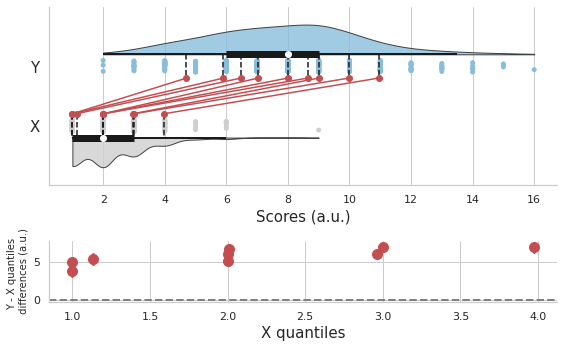

In [42]:
pg.plot_shift(matches_per_user.query("group==0")["size"], 
              matches_per_user.query("group==1")["size"])
plt.show()